<a href="https://colab.research.google.com/github/ArsalanKhan17/Flower-Classification/blob/main/Conv_architectures_flowerdata_week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Tutorial: Flower Image Prediction
1. Getting image data in, preprocessing it, and fitting a model



In [1]:
# Colab Setup: 
# note that tabular preprocessors require scikit-learn>=0.24.0
# Newest Tensorflow 2 has some bugs for onnx conversion
!pip install scikit-learn --upgrade 
import os
os.environ['TF_KERAS'] = '1'
% tensorflow_version 1

     |████████████████████████████████| 23.2 MB 57.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [2]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3




In [3]:
# Importing images from tensorflow compressed tgz file and saving them to folder

FLOWERS_DIR="flower_photos" # downloading to this directory drom the download url
def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(FLOWERS_DIR):
    DOWNLOAD_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
    print('Downloading flower images from %s...' % DOWNLOAD_URL)
    urllib.request.urlretrieve(DOWNLOAD_URL, 'flower_photos.tgz')
    !tar xfz flower_photos.tgz
  print('Flower photos are located in %s' % FLOWERS_DIR)


import os
from six.moves import urllib


# Download the images to flower_photos folder
download_images()

Flower photos are located in flower_photos


In [4]:
# Extracting all filenames iteratively
base_path = 'flower_photos'
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# load file names to fnames list object
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:4]) #examples of file names

number of images for each category: [633, 898, 641, 699, 799]
[['flower_photos/daisy/19975899671_ebc42b7865_n.jpg', 'flower_photos/daisy/7189043225_2fe781439a_n.jpg', 'flower_photos/daisy/3962240986_0661edc43a_n.jpg', 'flower_photos/daisy/20289938802_e16fa9f23d.jpg', 'flower_photos/daisy/14167534527_781ceb1b7a_n.jpg', 'flower_photos/daisy/302782756_d35cb3e468.jpg', 'flower_photos/daisy/12348343085_d4c396e5b5_m.jpg', 'flower_photos/daisy/2213954589_c7da4b1486.jpg', 'flower_photos/daisy/517054467_d82d323c33_m.jpg', 'flower_photos/daisy/2561371688_c80a4fe957_n.jpg', 'flower_photos/daisy/4563059851_45a9d21a75.jpg', 'flower_photos/daisy/19280272025_57de24e940_m.jpg', 'flower_photos/daisy/2513618768_ff7c004796_m.jpg', 'flower_photos/daisy/367020749_3c9a652d75.jpg', 'flower_photos/daisy/5765646947_82e95a9cc9_n.jpg', 'flower_photos/daisy/18203367608_07a04e98a4_n.jpg', 'flower_photos/daisy/3639009391_0f910681b7.jpg', 'flower_photos/daisy/2877860110_a842f8b14a_m.jpg', 'flower_photos/daisy/543552

In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.


        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
preprocessor('flower_photos/daisy/11642632_1e7627a2cc.jpg').shape


(192, 192, 3)

In [6]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
flower_filepaths=fnames[0]+fnames[1]+fnames[2]+fnames[3]+fnames[4]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,flower_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [7]:
X.shape #Imported 3670 observations

(3670, 192, 192, 3)

In [8]:
print(len(preprocessed_image_data) ) #same number of elements as filenames
print(preprocessed_image_data[0].shape ) #dimensions now 192,192,3 for all images
print(preprocessed_image_data[0].min() ) #min value of every image is zero
print(preprocessed_image_data[0].max() ) #max value of every image is one
X.shape # 

3670
(192, 192, 3)
0.0
1.0


(3670, 192, 192, 3)

In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
daisy=list(repeat("daisy", 633))
dandelion=list(repeat("dandelion", 898))
roses=list(repeat("roses", 641))
sunflowers=list(repeat("sunflowers", 699))
tulips=list(repeat("tulips", 799))

#combine into single list of y labels
y_labels = daisy+dandelion+roses+sunflowers+tulips

#check length, same as X above
len(y_labels) 

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [633, 898, 641, 699, 799]


,daisy,dandelion,roses,sunflowers,tulips
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
...,...,...,...,...,...
3665,0,0,0,0,1
3666,0,0,0,0,1
3667,0,0,0,0,1
3668,0,0,0,0,1


In [10]:
X[0].shape

(192, 192, 3)

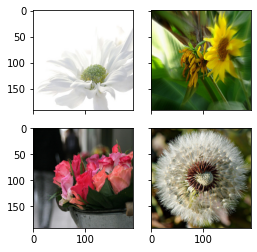

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

im1 =preprocessor('flower_photos/daisy/11642632_1e7627a2cc.jpg')
im2 =preprocessor('flower_photos/sunflowers/5556633113_0a04f5ed8a_n.jpg')
im3 =preprocessor('flower_photos/roses/3052753519_d087aaeacb_n.jpg')
im4 =preprocessor('flower_photos/dandelion/2019520447_48b2354a20_m.jpg')

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [im1, im2, im3, im4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()
        

In [ ]:
# Train test split resized images
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)


y_train 

,daisy,dandelion,roses,sunflowers,tulips
1450,0,1,0,0,0
2186,0,0,0,1,0
810,0,1,0,0,0
3619,0,0,0,0,1
67,1,0,0,0,0
...,...,...,...,...,...
1130,0,1,0,0,0
1294,0,1,0,0,0
860,0,1,0,0,0
3507,0,0,0,0,1


In [ ]:
X_train.shape

(2936, 192, 192, 3)

## Back to example code for Keras Convolutional Neural Net:

In [ ]:
# Let's set a baseline plain vanilla network model to use as a baseline for convnet models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout,BatchNormalization,Flatten
from tensorflow.keras.optimizers import SGD
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
      opt=SGD(lr=.001)

      model = Sequential()
      model.add(Dense(64,  input_shape=(192, 192, 3), activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Dense(64, activation='relu'))
      model.add(Flatten())
      model.add(Dense(5, activation='softmax')) 
                                                  
      # Compile model
      model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

      # Fitting the NN to the Training set
      model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 24s 8ms/sample - loss: 1.4837 - acc: 0.3716 - val_loss: 1.3785 - val_acc: 0.4060
Epoch 2/5
2936/2936 [==============================] - 23s 8ms/sample - loss: 1.3173 - acc: 0.4547 - val_loss: 1.2597 - val_acc: 0.4768
Epoch 3/5
2936/2936 [==============================] - 23s 8ms/sample - loss: 1.2456 - acc: 0.4864 - val_loss: 1.2156 - val_acc: 0.4714
Epoch 4/5
2936/2936 [==============================] - 23s 8ms/sample - loss: 1.2028 - acc: 0.4980 - val_loss: 1.1814 - val_acc: 0.5068
Epoch 5/5
2936/2936 [==============================] - 23s 8ms/sample - loss: 1.1664 - acc: 0.5235 - val_loss: 1.1900 - val_acc: 0.4986


{'name': 'SGD', 'learning_rate': 0.001, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
{'name': 'sequential', 'layers': [{'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': No

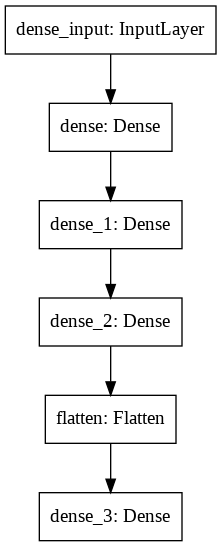

In [ ]:
import tensorflow.keras.backend as K

print(K.eval(model.optimizer.get_config()))

print(model.get_config())

print(len(model.history.epoch))
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
from tensorflow.keras.models import model_from_yaml

yaml_string = model.to_yaml()
model = model_from_yaml(yaml_string)



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
print(yaml_string)

backend: tensorflow
class_name: Sequential
config:
  layers:
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      batch_input_shape: !!python/tuple [null, 192, 192, 3]
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}
      kernel_regularizer: null
      name: dense
      trainable: true
      units: 64
      use_bias: true
  - class_name: Dense
    config:
      activation: relu
      activity_regularizer: null
      bias_constraint: null
      bias_initializer:
        class_name: Zeros
        config: {dtype: float32}
      bias_regularizer: null
      dtype: float32
      kernel_constraint: null
      kernel_initializer:
        class_name: GlorotUniform
        config: {dtype: float32, seed: null}

In [ ]:

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=1, filters=8, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 5 categories
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  #from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  #red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1) # dividing lr by 10 when val_accuracy fails to improve after 3 epochs

  model.compile(
    optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test)) #, callbacks=[red_lr]) for callback that automatically adjusts lr

Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 15s 5ms/sample - loss: 1.5013 - acc: 0.2902 - val_loss: 1.3822 - val_acc: 0.3324
Epoch 2/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 1.2874 - acc: 0.4104 - val_loss: 1.2258 - val_acc: 0.4728
Epoch 3/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 1.1352 - acc: 0.5521 - val_loss: 1.1253 - val_acc: 0.5313
Epoch 4/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 1.0291 - acc: 0.5906 - val_loss: 1.1389 - val_acc: 0.5272
Epoch 5/5
2936/2936 [==============================] - 9s 3ms/sample - loss: 0.9801 - acc: 0.6069 - val_loss: 1.0802 - val_acc: 0.5504


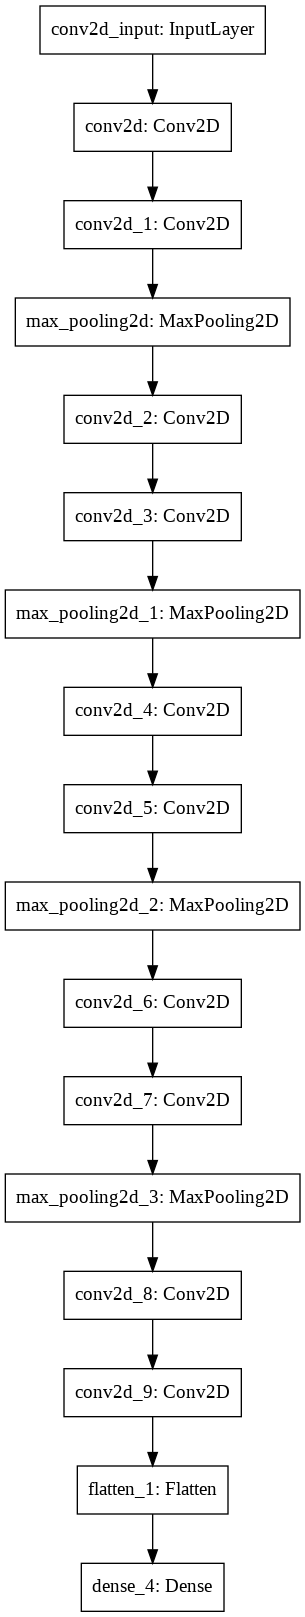

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# Let's build a squeezenet model instead to see how well it performs 
# Does adding more layers help (i.e.- try building a deeper and deeper network)

l = tf.keras.layers # syntax shortcut

# Create function to define fire modules
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y) # note: //2 takes input value and divides by 2, so we reach the dimensions requested with stacking later.
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)


with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
            x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

            y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
            y = fire_module(24, 48)(y)
            y = tf.keras.layers.GlobalAveragePooling2D()(y) # Takes average of h x w for each channel and returns 1 scalar value per channel
            y = tf.keras.layers.Dense(5, activation='softmax')(y) # Parameters for final layer from GAP = number of channels in previous layer plus number of dense nodes in output layer times number of dense nodes

            model = tf.keras.Model(x, y)
        
            model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 
        
            model.fit(X_train, y_train, 
                    epochs = 5, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 19s 7ms/sample - loss: 1.4658 - acc: 0.3515 - val_loss: 1.3909 - val_acc: 0.3896
Epoch 2/5
2936/2936 [==============================] - 16s 6ms/sample - loss: 1.2957 - acc: 0.4520 - val_loss: 1.2235 - val_acc: 0.4401
Epoch 3/5
2936/2936 [==============================] - 16s 6ms/sample - loss: 1.2443 - acc: 0.4578 - val_loss: 1.2391 - val_acc: 0.4223
Epoch 4/5
2936/2936 [==============================] - 16s 6ms/sample - loss: 1.2145 - acc: 0.4823 - val_loss: 1.1898 - val_acc: 0.4687
Epoch 5/5
 576/2936 [====>.........................] - ETA: 12s - loss: 1.1930 - acc: 0.4722

In [ ]:
import tensorflow.keras.backend as K

print(model.get_config()) # Full configuration to fit keras model
print(K.eval(model.optimizer.get_config())) # Optimizer configuration
print(len(model.history.epoch)) # Number of epochs


{'name': 'model', 'layers': [{'name': 'input_2', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 192, 192, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'inbound_nodes': []}, {'name': 'conv2d_11', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_11', 'trainable': True, 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None, 'dtype': 'float32'}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {'dtype': 'float32'}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'name': 'conv2d_12', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_12', 'trainable': True, 'dtype': 'float32', 'filter

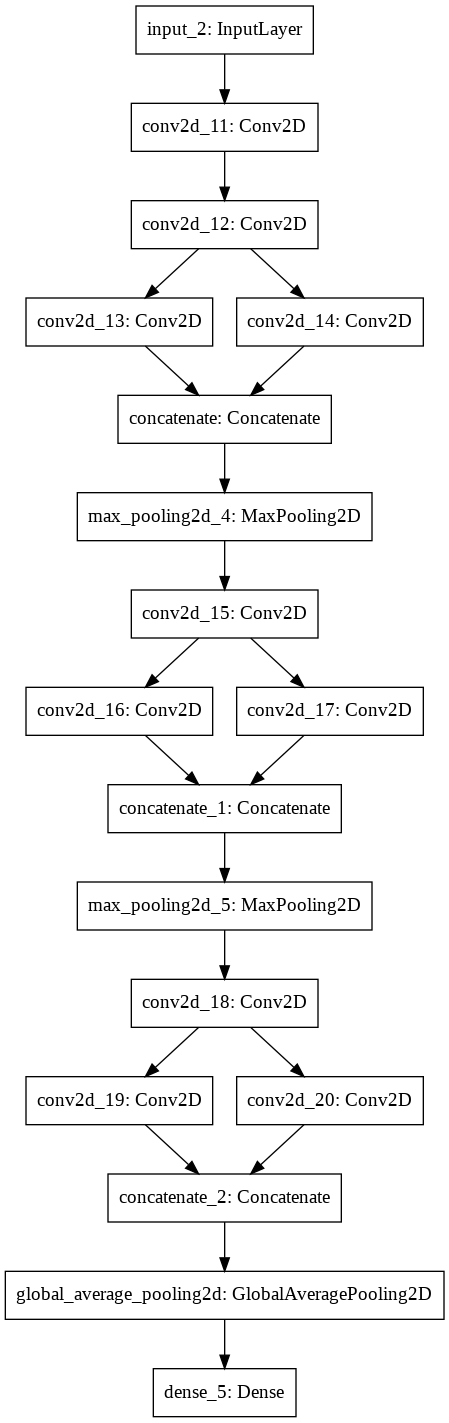

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [ ]:
# visualize the shallow network we created that uses fire modules


x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(5, activation='softmax')(y)

model = tf.keras.Model(x, y)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 192, 192, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 192, 192, 24) 792         conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 192, 192, 24) 600         conv2d_22[0][0]                  
____________________________________________________________________________________________

In [ ]:
# Adding batch normalization to assist with optimization for deeper network

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization()(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization()(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization()(y3)
    return tf.keras.layers.concatenate([y1, y3])

  def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

  x = tf.keras.layers.Input(shape=[192,192, 3]) # input is 192x192 pixels RGB

  y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same',  activation='relu')(x)
  y = tf.keras.layers.BatchNormalization()(y)
  y = fire_module(24, 48)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(48, 96)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(64, 128)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(72, 256)(y)
  y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
  y = fire_module(96, 512)(y)
  y = tf.keras.layers.GlobalAveragePooling2D()(y)
  y = tf.keras.layers.Dense(5, activation='softmax')(y)

  model = tf.keras.Model(x, y)

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 5, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/5
2936/2936 [==============================] - 38s 13ms/sample - loss: 1.1302 - acc: 0.5681 - val_loss: 1.7183 - val_acc: 0.2262
Epoch 2/5
2936/2936 [==============================] - 34s 12ms/sample - loss: 0.9153 - acc: 0.6557 - val_loss: 2.9103 - val_acc: 0.2262
Epoch 3/5
2936/2936 [==============================] - 34s 12ms/sample - loss: 0.7919 - acc: 0.7037 - val_loss: 2.4034 - val_acc: 0.2357
Epoch 4/5
2936/2936 [==============================] - 34s 12ms/sample - loss: 0.7195 - acc: 0.7340 - val_loss: 1.6485 - val_acc: 0.4128
Epoch 5/5
2936/2936 [==============================] - 34s 12ms/sample - loss: 0.6675 - acc: 0.7483 - val_loss: 1.9062 - val_acc: 0.4605


In [ ]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model.predict(X_test)))

prediction_index=predict_classes(model.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method

predicted_labels=list(map(lambda x: labels[x], prediction_index))
print(predicted_labels)

[1 3 4 1 1 4 3 1 1 1 1 1 1 1 1 4 1 1 1 1 4 4 1 1 1 1 4 4 3 1 1 4 1 4 4 1 1
 1 1 1 4 1 4 3 1 1 4 1 3 2 1 1 1 4 1 3 1 2 4 1 1 4 1 1 1 1 1 1 1 4 4 1 4 4
 1 1 1 3 4 4 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 3 0 1 1 1 2 1 1 1 1 1 1
 1 1 4 1 2 1 2 2 4 1 1 1 4 1 1 2 1 1 1 4 1 4 1 3 1 1 1 3 1 4 4 1 4 1 4 1 1
 1 1 1 1 1 1 1 3 4 4 1 1 2 1 1 1 3 2 1 4 1 1 4 1 1 2 4 1 4 1 1 2 1 1 1 1 4
 4 1 3 1 1 4 1 1 1 1 4 1 4 1 3 1 0 4 1 1 1 1 4 4 1 1 3 4 1 1 4 1 1 1 1 1 1
 1 1 1 1 1 1 1 4 1 2 1 1 1 1 4 1 1 1 2 1 1 2 1 1 1 1 1 4 1 1 3 1 1 4 2 3 4
 1 3 1 3 1 4 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 4 3 1 3 1 1 1 1 2 4 1
 1 1 1 4 1 1 3 1 1 3 1 1 2 1 1 4 1 1 3 1 1 1 3 1 4 1 1 2 3 1 1 1 4 1 1 1 1
 1 4 1 4 4 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 4 1 2 1 1 2 3 2 4 1 1 0 1 1 1 3 1
 1 1 3 4 1 1 1 1 1 3 1 4 1 3 2 1 1 1 3 1 1 2 1 1 1 3 1 4 1 1 1 1 3 1 1 1 4
 1 1 1 1 1 1 1 1 1 4 1 1 1 1 3 4 1 1 1 1 1 1 1 4 1 1 1 1 1 4 1 2 4 3 1 1 4
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 3 2 4 4 1 4 1 1 1 3 1 1 1 1 1 3 3 1 1 1 1 1
 1 1 0 1 1 1 1 1 4 1 1 1 

In [ ]:
# Now we can extract some evaluative metrics to use for model submission

import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro",zero_division=0)
        precision_eval = precision_score(y_true, y_pred,average="macro",zero_division=0)
        recall_eval = recall_score(y_true, y_pred,average="macro",zero_division=0)
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata



In [ ]:
# y_test is one hot encoded so we need to extract labels before runing model_eval_metrics()
y_test_labels=y_test.idxmax(axis=1) #extract labels from one hot encoded y_test object

y_test.idxmax(axis=1) #returns a pandas series of predicted labels

179          daisy
2679    sunflowers
3542        tulips
1061     dandelion
1091     dandelion
           ...    
2066         roses
2484    sunflowers
1025     dandelion
1681         roses
1454     dandelion
Length: 734, dtype: object

In [ ]:
# get metrics
model_eval_metrics( y_test_labels,predicted_labels,classification="TRUE")



,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.46049,0.41891,0.637145,0.443668,0,0,0,0


## Transfer Learning: Start with pre-established weights and retrain model final output layer to fit new output layer parameters to your data.

Different ways we might use a pretrained model:

1.   The pre-trained model is used directly to classify new images.
2.   The pre-trained model, or some portion of the model, is integrated into a new model, but layers of the pre-trained model are frozen during training. 
3.   Weight Initialization: The pre-trained model, or some portion of the model, is integrated into a new model, and the layers of the pre-trained model are trained in concert with the new model. Takes more computational power b/c we are fitting complete model (i.e.-VGGNet has lots of parameters to train!)




In [ ]:
# Quick explantory example before full code examples below
# Create the base model from the pre-trained model VGG16
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(192,192,3),
                                               include_top=False, # Drops fully connected layers and output layer structure from pretrained model.
                                               weights='imagenet') # Using weight from model trained to 1000 categories of imagenet competition
base_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
______________________________________________________________

In [ ]:
# example of loading the vgg16 model
from tensorflow.keras.applications import VGG16
# load model
model = VGG16()

# summarize the model
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
# example of loading the vgg16 model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary()


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [ ]:
# Next step: Freeze the weights of the VGG16 model so that they are not trained when you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 192, 192, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 192, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 192, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 96, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 96, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 96, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 48, 128)       0     

In [ ]:
from keras.regularizers import l2
model = Sequential([
  base_model,
   Conv2D(512,(1,1),padding="same", activation="relu"),
   Conv2D(1024,(3,3),padding="same", activation="relu"),
   Conv2D(1024,(3,3),padding="same", activation="relu"),
   GlobalAveragePooling2D(),
   Dense(5,activation="softmax")
])

model.summary()

Using TensorFlow backend.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 6, 6, 512)         262656    
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 6, 6, 1024)        4719616   
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 6, 6, 1024)        9438208   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5125      
Total params: 29,140,293
Trainable params: 14,425,605
Non-trainable params: 14,714,688
_________________________________

In [ ]:

# Fit VGG16 model with frozen imagent weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.
  from tensorflow.python.keras.callbacks import ReduceLROnPlateau
  from tensorflow.python.keras.callbacks import ModelCheckpoint
  
  mc = ModelCheckpoint('best_model.h5', monitor='val_acc',mode='max', verbose=1, save_best_only=True) # evaluating val_acc maximization
  red_lr= ReduceLROnPlateau(monitor='val_acc',patience=2,verbose=1,factor=0.5, min_lr=0.001) # dividing lr by 2 when val_accuracy fails to improve after 2 epochs

  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc']) 

  model.fit(X_train, y_train,batch_size=1,
          epochs = 10, verbose=1,validation_data=(X_test,y_test),callbacks=[mc,red_lr])

Train on 2936 samples, validate on 734 samples
Epoch 1/10
2934/2936 [============================>.] - ETA: 0s - loss: 1.0849 - acc: 0.5648
Epoch 00001: val_acc improved from -inf to 0.67030, saving model to best_model.h5
2936/2936 [==============================] - 148s 50ms/sample - loss: 1.0850 - acc: 0.5647 - val_loss: 0.9156 - val_acc: 0.6703
Epoch 2/10
2934/2936 [============================>.] - ETA: 0s - loss: 0.7975 - acc: 0.7059
Epoch 00002: val_acc did not improve from 0.67030
2936/2936 [==============================] - 146s 50ms/sample - loss: 0.7979 - acc: 0.7057 - val_loss: 1.0709 - val_acc: 0.5899
Epoch 3/10
2934/2936 [============================>.] - ETA: 0s - loss: 0.6733 - acc: 0.7502
Epoch 00003: val_acc improved from 0.67030 to 0.71390, saving model to best_model.h5
2936/2936 [==============================] - 147s 50ms/sample - loss: 0.6729 - acc: 0.7503 - val_loss: 0.8315 - val_acc: 0.7139
Epoch 4/10
2935/2936 [============================>.] - ETA: 0s - loss: 0

In [ ]:
import numpy as np
#Extract learning rate callback
learning_rates=model.history.history['lr'] # learning rates at each epoch

best_model_epoch=np.argmax(model.history.history['val_acc'])+1 # epoch of best model

print(learning_rates)
print(best_model_epoch)

[0.01, 0.01, 0.01, 0.01, 0.005, 0.005, 0.005, 0.0025, 0.0025, 0.00125]
10


## Plenty of trainable models we can use taking same approach:
## See all here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

### **Next example - Inception + Resnet model with same approach to transfer learning as above:**

In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

219062272/219055592 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 95, 95, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 95, 95, 32)   96          conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 95, 95, 32)   0           batch_normalization_16[0][0]     
_____________

In [ ]:
# Next step: Freeze the weights of the model so that they are not trained with you fit the model
# setting the entire model's trainable flag to False will freeze all the layers.

base_model.trainable = False

base_model.summary() # Note the trainable parameters at the bottom now equal zero.

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 95, 95, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_219 (BatchN (None, 95, 95, 32)   96          conv2d_275[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 95, 95, 32)   0           batch_normalization_219[0][0]    
________________________________________________________________________________

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
model = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(5,activation="softmax")
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 7685      
Total params: 54,344,421
Trainable params: 7,685
Non-trainable params: 54,336,736
_________________________________________________________________


In [ ]:
# Fit Inception model with frozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 25, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/25
2936/2936 [==============================] - 27s 9ms/sample - loss: 1.0070 - acc: 0.6482 - val_loss: 2.4870 - val_acc: 0.5095
Epoch 2/25
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.6357 - acc: 0.8038 - val_loss: 2.1373 - val_acc: 0.6144
Epoch 3/25
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.5506 - acc: 0.8260 - val_loss: 1.6395 - val_acc: 0.6717
Epoch 4/25
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.4990 - acc: 0.8433 - val_loss: 1.6630 - val_acc: 0.6839
Epoch 5/25
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.4581 - acc: 0.8607 - val_loss: 1.5768 - val_acc: 0.6962
Epoch 6/25
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.4359 - acc: 0.8576 - val_loss: 1.8319 - val_acc: 0.6621
Epoch 7/25
2936/2936 [==============================] - 15s 5ms/sample - loss: 0.4261 - acc: 0.8590 - val_loss: 1.7200 - val_acc: 0

## What if we unfreeze some of the layers from the inception model?

In [ ]:
# example of loading the Inception model
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras import backend as K


# load model new input layer shape.

IMG_SHAPE = (192, 192, 3)

# Create the base model from the pre-trained model VGG16
base_model = InceptionResNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.summary() # Notice unfrozen number of trainable parameters

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_478 (Conv2D)             (None, 95, 95, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_422 (BatchN (None, 95, 95, 32)   96          conv2d_478[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 95, 95, 32)   0           batch_normalization_422[0][0]    
________________________________________________________________________________

In [ ]:
len(base_model.trainable_variables) #488 trainable layers


488

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune everything up to this layer onwards
freeze_layers_after=10

# Freeze all the layers after the `freeze_layers_after` layer
for layer in base_model.layers[freeze_layers_after:]:
  layer.trainable =  False

print("Number of layers frozen in the base model: ", len(base_model.layers)-freeze_layers_after)


Number of layers in the base model:  780
Number of layers frozen in the base model:  770


In [ ]:
len(base_model.trainable_variables) #6 trainable layers after freezing

6

In [ ]:
# Add new GAP layer and output layer to frozen layers of original model with adjusted input
model = Sequential([
  base_model,
   GlobalAveragePooling2D(),
   Dense(5,activation="softmax")
])

model.summary() #not showing up in model summary, but your trainable paramaters have just increased by a huge amount!

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 7685      
Total params: 54,344,421
Trainable params: 36,325
Non-trainable params: 54,308,096
_________________________________________________________________


In [ ]:
# Fit Inception model with some unfrozen imagenet weights and new input/output layer shapes (outputs have trainable parameters)

with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc']) 

  model.fit(X_train, y_train,
          epochs = 25, verbose=1,validation_data=(X_test,y_test))

Train on 2936 samples, validate on 734 samples
Epoch 1/25
2936/2936 [==============================] - 68s 23ms/sample - loss: 0.3680 - acc: 0.8757 - val_loss: 2.0558 - val_acc: 0.6894
Epoch 2/25
2936/2936 [==============================] - 24s 8ms/sample - loss: 0.3214 - acc: 0.8934 - val_loss: 2.2924 - val_acc: 0.6798
Epoch 3/25
2936/2936 [==============================] - 24s 8ms/sample - loss: 0.3230 - acc: 0.8951 - val_loss: 2.1342 - val_acc: 0.6880
Epoch 4/25
2936/2936 [==============================] - 24s 8ms/sample - loss: 0.2944 - acc: 0.9029 - val_loss: 2.1086 - val_acc: 0.6935
Epoch 5/25
2936/2936 [==============================] - 24s 8ms/sample - loss: 0.3177 - acc: 0.8873 - val_loss: 2.4164 - val_acc: 0.6703
Epoch 6/25
2936/2936 [==============================] - 24s 8ms/sample - loss: 0.3874 - acc: 0.8655 - val_loss: 2.1090 - val_acc: 0.6935
Epoch 7/25
2936/2936 [==============================] - 24s 8ms/sample - loss: 0.3267 - acc: 0.8907 - val_loss: 2.5053 - val_acc: 